In [1]:
import utils
utils.assign_free_gpus()
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

No GPU available, using CPU


### Dataset

In [2]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # normalization:
    torchvision.transforms.Normalize(0.5, 0.5,)

])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

  0%|          | 0/9912422 [00:00<?, ?it/s]

9913344it [00:00, 12940864.01it/s]                             


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw


29696it [00:00, 1979027.47it/s]          


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw




 16%|█▌        | 265216/1648877 [00:00<00:00, 2637729.63it/s]

1649664it [00:00, 4371596.42it/s]                             


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



5120it [00:00, ?it/s]                   

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw

The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [3]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 10)
        # No need to include softmax, as this is already combined in the loss function

    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

# function for the hidden layer
def create_model_hidden():
    model = nn.Sequential(
        nn.Flatten(),
        #64 nodes 
        nn.Linear(28*28*1, 64),
        # reLU activation function
        nn.ReLU(),
        #output layer with 64 and 10
        nn.Linear(64,10)
    )
    model = utils.to_cuda(model)
    return model

model_hidden = create_model_hidden()

In [4]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [5]:
# Hyperparameters
learning_rate = .0192
#learning_rate = 1.0
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

#optimizer for the hidden layer
optimizer_hidden = torch.optim.SGD(model_hidden.parameters(), 
                                   lr=learning_rate)


### Train model

In [6]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

# created a new trainer with the hidden layer elements
trainer_hidden = Trainer(
  model=model_hidden,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer_hidden
)
train_loss_dict_hidden, test_loss_dict_hidden = trainer_hidden.train(num_epochs)


Training epoch 4: 100%|██████████| 938/938 [00:15<00:00, 61.36it/s]


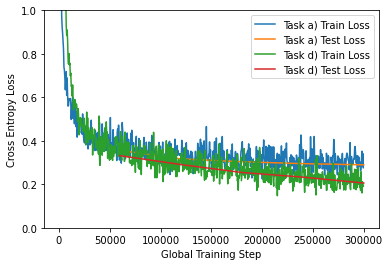

Final Test loss: 0.28952102848346445. Final Test accuracy: 0.9176


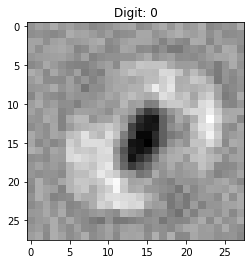

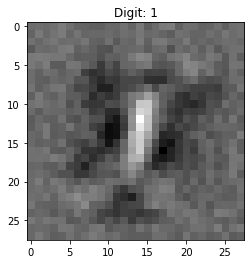

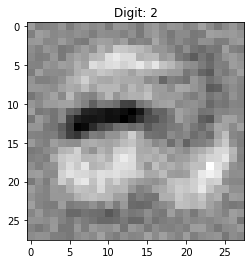

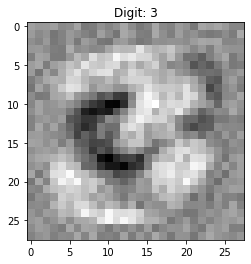

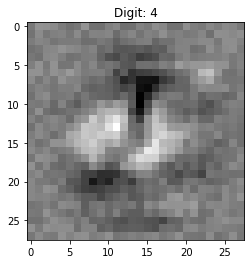

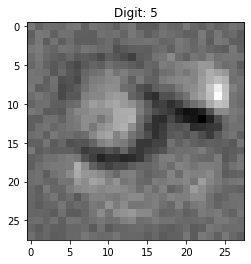

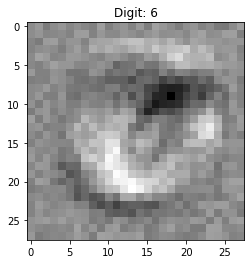

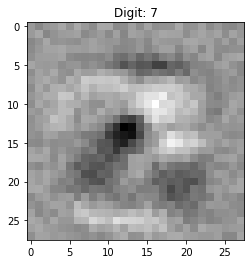

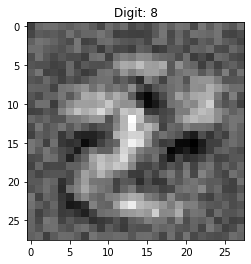

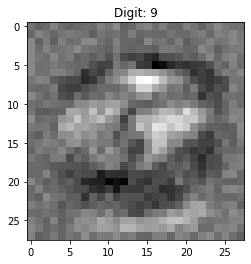

In [7]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Task a) Train Loss")
utils.plot_loss(test_loss_dict, label="Task a) Test Loss")

#task d)
utils.plot_loss(train_loss_dict_hidden, label="Task d) Train Loss")
utils.plot_loss(test_loss_dict_hidden, label="Task d) Test Loss")


# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

weight = list(model.children())[1].weight.cpu().data

for i in range(10):
    weight_new = weight[i].view(28, 28)
    plt.figure()
    plt.title(f"Digit: {i}")
    plt.imshow(weight_new, cmap='gray')
    plt.show() 


## Plotting example

In [8]:
# You can delete the remaining code of this notebook, as this is just to illustrate one method to solve the assignment tasks.


# This example code is here to illustrate how you can plot two different models to compare them.
# Lets change a small part of our model: the number of epochs trained (NOTE, use 5 epochs for your experiments in the assignment.)

# We reset the manual seed to 0, such that the model parameters are initialized with the same random number generator.
torch.random.manual_seed(0)
np.random.seed(0)


dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
model = create_model()

learning_rate = .0192
num_epochs = 6

# Redefine optimizer, as we have a new model.
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_6epochs, test_loss_dict_6epochs = trainer.train(num_epochs)
num_epochs = 5

Training epoch 5: 100%|██████████| 938/938 [00:14<00:00, 62.66it/s]


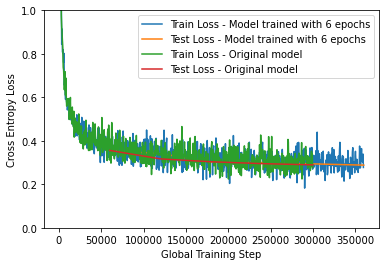

Final Test loss: 0.2881942022188454. Final Test accuracy: 0.9196


In [9]:
# We can now plot the two models against eachother

# Plot loss
utils.plot_loss(train_loss_dict_6epochs, label="Train Loss - Model trained with 6 epochs")
utils.plot_loss(test_loss_dict_6epochs, label="Test Loss - Model trained with 6 epochs")
utils.plot_loss(train_loss_dict, label="Train Loss - Original model")
utils.plot_loss(test_loss_dict, label="Test Loss - Original model")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")

plt.show()

torch.save(model.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")

### Task A

### Task B

### Task C

### Task D